<a href="https://colab.research.google.com/github/ikram2500/pytorch/blob/main/image_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.get the data from kaggle

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hmikram info
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:10<00:00, 68.7MB/s]


**2. Import libraries**

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms, ToTensor, Normalize, Compose, Resize
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **3. Get the data into one folder and then create data frame**

In [3]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):

  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):

    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
print(data_df['labels'].unique())
data_df.head()

['wild' 'cat' 'dog']


,image_path,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild
2,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


# 4. Split the data into train test and validation

In [4]:
train = data_df.sample(frac= 0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape, val.shape, test.shape )

(11291, 2) (2420, 2) (2419, 2)


# 5. Apply tranformation

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

# 6. Create Dataset

In [6]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(self.dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [7]:
train_dataset = CustomImageDataset(train, transform)
val_dataset = CustomImageDataset(val, transform)
test_dataset = CustomImageDataset(test, transform)

In [8]:
train_dataset.__len__()

11291

In [9]:
train_dataset.__getitem__(0)

(tensor([[[0.5490, 0.5137, 0.5216,  ..., 0.3529, 0.3725, 0.3529],
          [0.4627, 0.5490, 0.5647,  ..., 0.3882, 0.3451, 0.3843],
          [0.4902, 0.5020, 0.5765,  ..., 0.4588, 0.4039, 0.4588],
          ...,
          [0.4235, 0.3412, 0.3020,  ..., 0.4706, 0.4196, 0.5765],
          [0.4235, 0.3765, 0.3216,  ..., 0.4314, 0.3765, 0.4431],
          [0.3686, 0.3843, 0.3294,  ..., 0.3725, 0.4275, 0.3882]],
 
         [[0.4863, 0.4627, 0.4863,  ..., 0.4157, 0.4353, 0.4039],
          [0.4118, 0.5020, 0.5255,  ..., 0.4588, 0.4118, 0.4314],
          [0.4510, 0.4549, 0.5255,  ..., 0.5490, 0.4745, 0.5020],
          ...,
          [0.3961, 0.3294, 0.3137,  ..., 0.4353, 0.4196, 0.5294],
          [0.3922, 0.3490, 0.3020,  ..., 0.4039, 0.3922, 0.4196],
          [0.3333, 0.3490, 0.2941,  ..., 0.3412, 0.4510, 0.3804]],
 
         [[0.3843, 0.3490, 0.3569,  ..., 0.2314, 0.2471, 0.2235],
          [0.3137, 0.4000, 0.4118,  ..., 0.2784, 0.2392, 0.2627],
          [0.3686, 0.3686, 0.4314,  ...,

# 7. Plot Random images

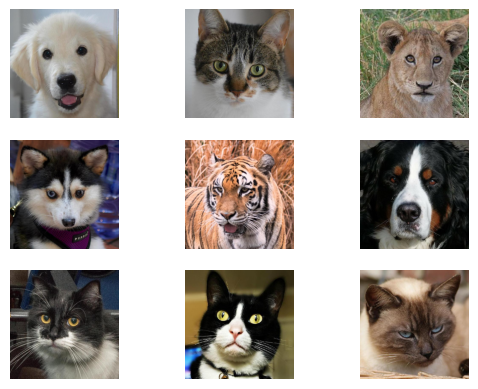

In [10]:
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols,)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n = 1)['image_path'].iloc[0]).convert('RGB')
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show()

# 8. Hyperparameters

In [11]:
lr = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 9. Model Building

`in the first convulution the edges are detected and 3 channels when rgb and output is 32 . then the input of 2nd layer is output of 1st layer. 32 and the output is 64 .after Ist convulution increases the number of features. But this does not mean the size of the image increases. size remains 128*128. kernel is 3*3. then apply pooling layer . pooling does not reduces the size of the output features but reduces the amount of the features 64*64, it is not affected the size of the image. layer on a given condition like max, avg, pooling its here 2d`

In [13]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding= 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding= 1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding= 1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x) #-> (32, 128, 128)
    x = self.pooling(x) # -> (32, 64, 64)
    x = self.relu(x)

    x = self.conv2(x) #-> (32, 64, 64)
    x= self.pooling(x) #-> (64, 32, 32)
    x = self.relu(x)

    x = self.conv3(x) #-> (64, 32, 32)
    x = self.pooling(x) #-> (128, 16, 16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [14]:
model = Net().to(device)

In [15]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

# 10. Calculate loss and accuracy

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= lr)

In [17]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_loss_train = 0
  total_loss_validation = 0

  total_acc_train = 0
  total_acc_validation = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_validation += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_validation += val_acc

  total_loss_train_plot.append(total_loss_train/len(train_loader))
  total_loss_validation_plot.append(total_loss_validation/len(val_loader))

  total_acc_train_plot.append(total_acc_train/len(train_loader))
  total_acc_validation_plot.append(total_acc_validation/len(val_loader))

  print(f"""Epoch: {epoch+1}/{EPOCHS} | Train Loss: {round(total_loss_train/1000,4)} rain Acc: {round(total_acc_train/train_dataset.__len__()* 100,4)}
        Val Loss: {round(total_loss_validation/1000, 4)} | Val Acc: {round(total_acc_validation/val_dataset.__len__() *100,4)}""")


Epoch: 1/10 | Train Loss: 0.3458 rain Acc: 79.249
        Val Loss: 0.0397 | Val Acc: 90.9504
Epoch: 2/10 | Train Loss: 0.1404 rain Acc: 92.7376
        Val Loss: 0.0277 | Val Acc: 93.7603
Epoch: 3/10 | Train Loss: 0.0926 rain Acc: 95.3414
        Val Loss: 0.0246 | Val Acc: 94.7107
Epoch: 4/10 | Train Loss: 0.0645 rain Acc: 96.7319
        Val Loss: 0.0202 | Val Acc: 95.0413
Epoch: 5/10 | Train Loss: 0.0503 rain Acc: 97.3873
        Val Loss: 0.0219 | Val Acc: 94.876
Epoch: 6/10 | Train Loss: 0.0365 rain Acc: 98.087
        Val Loss: 0.0179 | Val Acc: 96.157
Epoch: 7/10 | Train Loss: 0.0246 rain Acc: 98.7689
        Val Loss: 0.0221 | Val Acc: 95.7025
Epoch: 8/10 | Train Loss: 0.0188 rain Acc: 99.1055
        Val Loss: 0.0218 | Val Acc: 95.7025
Epoch: 9/10 | Train Loss: 0.0129 rain Acc: 99.3978
        Val Loss: 0.0252 | Val Acc: 95.7438
Epoch: 10/10 | Train Loss: 0.0155 rain Acc: 99.318
        Val Loss: 0.0262 | Val Acc: 95.8678


# Predictions

In [18]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:

    outputs = model(inputs)
    test_loss = criterion(outputs, labels)
    total_loss_test += test_loss.item()

    test_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_test += test_acc

  print(f"""Test Loss: {round(total_loss_test/1000,4)} | Test Acc: {round(total_acc_test/test_dataset.__len__() *100,4)}""")

Test Loss: 0.0215 | Test Acc: 96.0314


# Plotting of results

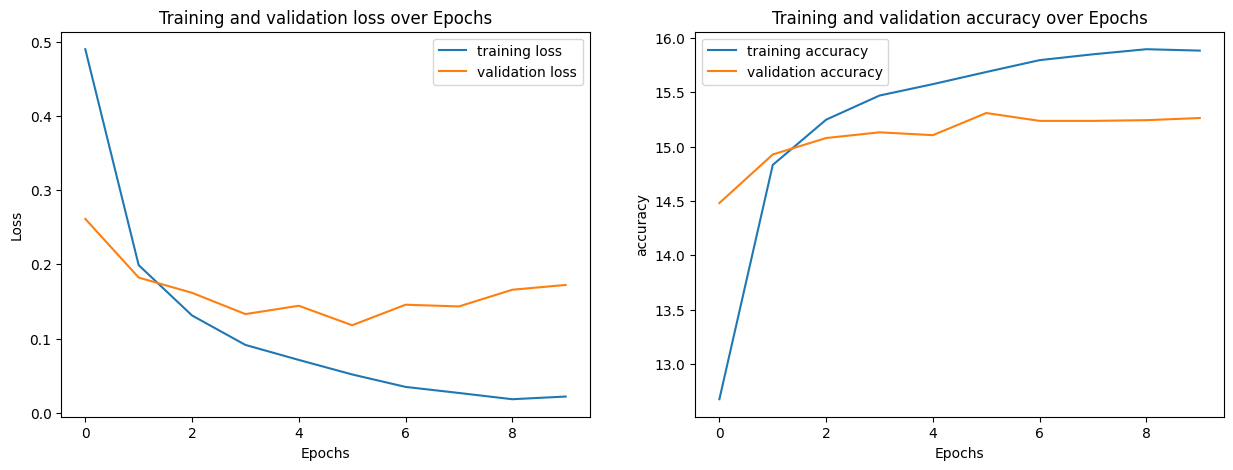

In [19]:
fig , axs = plt.subplots( 1,  2 , figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label = 'training loss')
axs[0].plot(total_loss_validation_plot, label = 'validation loss')
axs[0].set_title('Training and validation loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'training accuracy')
axs[1].plot(total_acc_validation_plot, label = 'validation accuracy')
axs[1].set_title('Training and validation accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('accuracy')
axs[1].legend()

plt.show()

# 13. inference

In [22]:
# 1- read image
# 2 - Transform using transform object

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()

  return label_encoder.inverse_transform([output])

In [23]:
predict_image("/content/Cat.jpeg")

array(['wild'], dtype=object)